In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

import pandas as pd
import numpy as np

from RoadDataset import RoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_datasets_path = "../notebooks/datasets/train/"
sub_dirs = os.listdir(train_datasets_path)
train_dataset_paths = [[train_datasets_path + sub_dir + "/" + sub_dir + ".csv", train_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
train_dataset_paths

[['../notebooks/datasets/train/Sun Dec 27 18_09_33 2020/Sun Dec 27 18_09_33 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 18_09_33 2020/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 17_46_56 2020/Sun Dec 27 17_46_56 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 17_46_56 2020/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 18_01_53 2020/Sun Dec 27 18_01_53 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 18_01_53 2020/frames/'],
 ['../notebooks/datasets/train/Wed Dec 30 17_34_37 2020/Wed Dec 30 17_34_37 2020.csv',
  '../notebooks/datasets/train/Wed Dec 30 17_34_37 2020/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 18_25_24 2020/Sun Dec 27 18_25_24 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 18_25_24 2020/frames/'],
 ['../notebooks/datasets/train/Wed Dec 30 17_38_58 2020/Wed Dec 30 17_38_58 2020.csv',
  '../notebooks/datasets/train/Wed Dec 30 17_38_58 2020/frames/'],
 ['../notebooks/datasets/train/Wed Dec 30 17_34_20 2020/Wed Dec 30 17_34_20 

In [4]:
val_datasets_path = "../notebooks/datasets/validation/"
sub_dirs = os.listdir(val_datasets_path)
val_dataset_paths = [[val_datasets_path + sub_dir + "/" + sub_dir + ".csv", val_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
val_dataset_paths

[['../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv',
  '../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/frames/'],
 ['../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv',
  '../notebooks/datasets/validation/Nacht-Schneechaos/frames/']]

In [5]:
#dataset_paths = [dataset_paths[3]]

In [6]:
dataset_index = 0
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
my_batch_size = 16

train_datasets = []
for train_dataset_path in train_dataset_paths:
    train_dataset = RoadDataset(train_dataset_path[0], train_dataset_path[1], column_names, batch_size=my_batch_size)
    train_dataset.clean()
    train_dataset.balance()
    train_dataset.normalize()
    print()
    if len(train_dataset) > 0:
        train_datasets.append(train_dataset)
        
val_datasets = []
for val_dataset_path in val_dataset_paths:
    val_dataset = RoadDataset(val_dataset_path[0], val_dataset_path[1], column_names, batch_size=my_batch_size)
    val_dataset.clean()
    val_dataset.normalize()
    print()
    if len(val_dataset) > 0:
        val_datasets.append(val_dataset)

Loaded dataset with 8096 samples
Cleaning dataset. Starting with 8096 samples.
Removing 2058 rows for reason: Low speed (< 25 km/h)
Removing 218 rows for reason: High SWA (> +45/ < -45 deg)
Removing 125 rows for reason: Left blinker on
Removing 1 rows for reason: Right blinker on
5694 samples remaining.
Balancing dataset. Starting with 5694 samples.
1736 samples remaining.

Loaded dataset with 3775 samples
Cleaning dataset. Starting with 3775 samples.
Removing 1290 rows for reason: Low speed (< 25 km/h)
Removing 231 rows for reason: High SWA (> +45/ < -45 deg)
Removing 65 rows for reason: Left blinker on
Removing 138 rows for reason: Right blinker on
2051 samples remaining.
Balancing dataset. Starting with 2051 samples.
1341 samples remaining.

Loaded dataset with 7060 samples
Cleaning dataset. Starting with 7060 samples.
Removing 1146 rows for reason: Low speed (< 25 km/h)
Removing 393 rows for reason: High SWA (> +45/ < -45 deg)
Removing 20 rows for reason: Left blinker on
Removing 2

In [7]:
train_sets = train_datasets
val_sets = val_datasets

In [8]:
len(train_sets)

14

In [9]:
len(val_sets)

2

In [10]:
#dataset.pairplot()

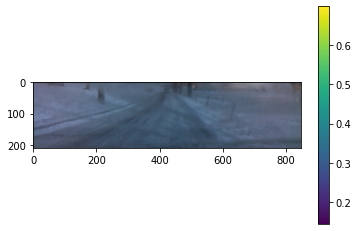

In [11]:
import matplotlib.pyplot as plt
image = train_sets[0].get_batch_features(0)[0]/255
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ELU, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Dropout, BatchNormalization

ch, row, col = 3, 210, 848

model = Sequential([
  Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch)),
  MaxPooling2D(pool_size=(1,3), strides=(1,3), padding='valid'),
    
  Conv2D(filters=16, kernel_size=(7,7), strides=(2,2), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
  Conv2D(filters=32, kernel_size=(5,5), strides=(2, 2), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
  Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
  Flatten(),
  Dropout(.2),
  #ELU(),
    
  Dense(64),
  Dropout(.5),
  ELU(),
  Dense(1)

])
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 210, 848, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 282, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 102, 138, 16)      2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 69, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 33, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 64)          5

In [14]:
import numpy as np
import matplotlib.pylab as plt


def get_smoothness_score(series):
    
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

    smooth = running_mean(series, 9)
    diff = series[4:-4] - smooth
    
    smoothness = 1/np.mean(np.abs(diff))
    print(smoothness)
    return smoothness

In [33]:
model_name = 'diypilot_v9_small_FC'
epochs = 200

for epoch in range(epochs):
    print("Starting Epoch {} for all datasets".format(epoch+1))
    for train_set in train_sets:
        model.fit(train_set, epochs=1, verbose=1, use_multiprocessing=False, workers=1)
        
    model.save('./trained_models/' + model_name + "_epoch_" + str(epoch+1) + '.h5')
        
    print()
    i = 1
    for val_set in val_sets:
        loss = model.evaluate(val_set, verbose=1)
        predictions = model.predict(val_set, verbose=1)
        predictions_degrees = [x[0]*90 for x in predictions.tolist()]
        get_smoothness_score(predictions_degrees)
        #print("Validation Set {} loss: {}".format(i, loss))
        i+=1
        
    print()
    print()
    

Starting Epoch 1 for all datasets
109/109 [==============================] - 20s 181ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.1021

530/530 [==============================] - 96s 180ms/step
0.12317141008309117
331/331 [==============================] - 59s 178ms/step
0.2253658290872073


Starting Epoch 2 for all datasets
109/109 [==============================] - 19s 176ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0691

530/530 [==============================] - 96s 180ms/step
0.12238413305457917
331/331 [==============================] - 60s 181ms/step
0.21810325979759315


Starting Epoch 3 for all datasets
109/109 [==============================] - 19s 177ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0587

530/530 [==============================] - 96s 181ms/step
0.12637096539838696
331/331 [==============================] - 59s 179ms/step
0.20194579443888094


Starting Epoch 4 for all datasets
109/109 [==============================] - 19s 178ms/step - loss: 0.0048 - mse: 0.004

109/109 [==============================] - 19s 175ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0497

530/530 [==============================] - 94s 178ms/step
0.12829961251612693
331/331 [==============================] - 58s 175ms/step
0.18850989206707422


Starting Epoch 6 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0491

530/530 [==============================] - 94s 178ms/step
0.12449687820093813
331/331 [==============================] - 58s 176ms/step
0.18096076914168027


Starting Epoch 7 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0512

530/530 [==============================] - 94s 178ms/step
0.11459930625685467
331/331 [==============================] - 58s 174ms/step
0.15667288131617066


Starting Epoch 8 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0469

530/530 [=======

109/109 [==============================] - 19s 174ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0467

530/530 [==============================] - 94s 178ms/step
0.11851355412353685
331/331 [==============================] - 58s 175ms/step
0.16368898489862943


Starting Epoch 11 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0462

530/530 [==============================] - 94s 178ms/step
0.11633072694458493
331/331 [==============================] - 58s 176ms/step
0.1624316705374187


Starting Epoch 12 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0472

530/530 [==============================] - 94s 178ms/step
0.12875707122396585
331/331 [==============================] - 58s 175ms/step
0.158482439966591


Starting Epoch 13 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0476

530/530 [=======

109/109 [==============================] - 19s 174ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0452

530/530 [==============================] - 94s 177ms/step
0.11344069712552583
331/331 [==============================] - 58s 176ms/step
0.15347817494010826


Starting Epoch 15 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0463

530/530 [==============================] - 94s 178ms/step
0.10837901458173656
331/331 [==============================] - 58s 176ms/step
0.14509117849561634


Starting Epoch 16 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0468

530/530 [==============================] - 94s 177ms/step
0.12479355522768205
331/331 [==============================] - 58s 174ms/step
0.15563483061643676


Starting Epoch 17 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0467

530/530 [====

109/109 [==============================] - 19s 174ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0456

530/530 [==============================] - 94s 178ms/step
0.11955710043214256
331/331 [==============================] - 58s 177ms/step
0.15794819971468638


Starting Epoch 20 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0449

530/530 [==============================] - 94s 177ms/step
0.12135767290724905
331/331 [==============================] - 58s 176ms/step
0.14344321448289096


Starting Epoch 21 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0462

530/530 [==============================] - 94s 177ms/step
0.11348575130619418
331/331 [==============================] - 58s 176ms/step
0.1445485590555695


Starting Epoch 22 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0442

530/530 [=====

530/530 [==============================] - 94s 178ms/step
0.12159546800172599
331/331 [==============================] - 58s 176ms/step
0.1579862345769111


Starting Epoch 24 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0444

530/530 [==============================] - 93s 176ms/step
0.12378765469520134
331/331 [==============================] - 58s 176ms/step
0.14834943912682688


Starting Epoch 25 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0460

530/530 [==============================] - 94s 178ms/step
0.13011579582555832
331/331 [==============================] - 58s 176ms/step
0.1716792705636656


Starting Epoch 26 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0475

530/530 [==============================] - 93s 176ms/step
0.12817494342268032
331/331 [==============================

109/109 [==============================] - 19s 174ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0459

530/530 [==============================] - 94s 178ms/step
0.11224606442765013
331/331 [==============================] - 58s 176ms/step
0.13714423770217565


Starting Epoch 29 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0443

530/530 [==============================] - 94s 178ms/step
0.11727524049156889
331/331 [==============================] - 58s 176ms/step
0.16017409730790177


Starting Epoch 30 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0446

530/530 [==============================] - 94s 178ms/step
0.12944557439943172
331/331 [==============================] - 58s 177ms/step
0.15004957962001278


Starting Epoch 31 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0443

530/530 [====

331/331 [==============================] - 58s 176ms/step
0.15052419664752045


Starting Epoch 33 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0463

530/530 [==============================] - 94s 178ms/step
0.1103140725140888
331/331 [==============================] - 58s 174ms/step
0.13738667961668052


Starting Epoch 34 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0450

530/530 [==============================] - 94s 178ms/step
0.11014156620861464
331/331 [==============================] - 58s 176ms/step
0.13853310916924189


Starting Epoch 35 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0418

530/530 [==============================] - 95s 179ms/step
0.111253435339434
331/331 [==============================] - 59s 177ms/step
0.13637874781750786


Starting Epoch 36 for all datasets
109

109/109 [==============================] - 19s 175ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0457

530/530 [==============================] - 94s 176ms/step
0.10767380280029618
331/331 [==============================] - 58s 177ms/step
0.1394279322587078


Starting Epoch 38 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0435

530/530 [==============================] - 93s 176ms/step
0.10458202475049484
331/331 [==============================] - 58s 174ms/step
0.12743966081471467


Starting Epoch 39 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0446

530/530 [==============================] - 94s 178ms/step
0.11428357822264489
331/331 [==============================] - 58s 177ms/step
0.15015488290572362


Starting Epoch 40 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0448

530/530 [=====

109/109 [==============================] - 19s 176ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0445

530/530 [==============================] - 94s 178ms/step
0.11308662438355707
331/331 [==============================] - 58s 176ms/step
0.14147506267411844


Starting Epoch 43 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0448

530/530 [==============================] - 93s 176ms/step
0.11987369294474905
331/331 [==============================] - 58s 176ms/step
0.1515207460949241


Starting Epoch 44 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0437

530/530 [==============================] - 94s 178ms/step
0.12641544401969113
331/331 [==============================] - 58s 176ms/step
0.1524522790517567


Starting Epoch 45 for all datasets
109/109 [==============================] - 19s 176ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0428

530/530 [======

109/109 [==============================] - 19s 175ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0460

530/530 [==============================] - 95s 179ms/step
0.12390985215020828
331/331 [==============================] - 58s 177ms/step
0.15716397414405364


Starting Epoch 47 for all datasets
109/109 [==============================] - 19s 176ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0454

530/530 [==============================] - 95s 179ms/step
0.1093289588242336
331/331 [==============================] - 59s 177ms/step
0.12473905705544105


Starting Epoch 48 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0459

530/530 [==============================] - 94s 178ms/step
0.12201639110478371
331/331 [==============================] - 58s 176ms/step
0.1497987175855918


Starting Epoch 49 for all datasets
109/109 [==============================] - 19s 174ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0458

530/530 [======

109/109 [==============================] - 19s 175ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0441

530/530 [==============================] - 95s 179ms/step
0.1283488921601059
331/331 [==============================] - 58s 175ms/step
0.16648526567893362


Starting Epoch 52 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0437

530/530 [==============================] - 94s 178ms/step
0.11918808635548442
331/331 [==============================] - 58s 177ms/step
0.1431217724346604


Starting Epoch 53 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0445

530/530 [==============================] - 95s 179ms/step
0.12374939219244105
331/331 [==============================] - 58s 176ms/step
0.1488020729723831


Starting Epoch 54 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0449

530/530 [=======

109/109 [==============================] - 19s 175ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0454

530/530 [==============================] - 94s 178ms/step
0.11116541381125183
331/331 [==============================] - 58s 176ms/step
0.16023883373574188


Starting Epoch 56 for all datasets
109/109 [==============================] - 19s 175ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0462

530/530 [==============================] - 95s 179ms/step
0.12780745212485078
331/331 [==============================] - 59s 177ms/step
0.16150103121393278


Starting Epoch 57 for all datasets
109/109 [==============================] - 19s 177ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0448

530/530 [==============================] - 94s 178ms/step
0.127136276146294
331/331 [==============================] - 59s 178ms/step
0.15333995222549476


Starting Epoch 58 for all datasets
95/99 [===========================>..] - ETA: 0s - loss: 0.0052 - mse: 0.0052 - mae: 0.0549

KeyboardInterrupt: 